# --- **Résolution de Sudoku avec Greedy Best First Search** ---

Ce notebook présente l'implémentation et l'évaluation de l'algorithme **Greedy Best First Search (GBFS)** pour résoudre des grilles de Sudoku (de taille `9x9`) en utilisant plusieurs fonctions heuristiques.  

L'objectif est de comparer l'impact de chaque heuristique sur les performances de l'algorithme (temps d'exécution, nombre d'états explorés, taille maximale de la file ouverte, taux de réussite).

GBFS est un algorithme de recherche informée qui sélectionne à chaque itération l'état estimé le plus proche de l'objectif, selon une fonction heuristique `h(n)`. Il ne prend pas en compte le coût déjà parcouru (`g(n)`), contrairement à A*, et met donc particulièrement en avant la qualité de l'heuristique choisie.

### **Heuristiques implémentées**

- **$h_1$ : Nombre de cases vides**  
  Calcule simplement le nombre de cellules non remplies dans la grille.  
  → Plus cette valeur est faible, plus l'état est considéré proche de la solution.  
  → Heuristique simple, rapide à calculer, mais peu discriminante lorsque plusieurs grilles ont le même nombre de cases vides.

- **$h_2$ : Somme des tailles des domaines**  
  Pour chaque cellule vide, on calcule l'ensemble des valeurs légales (domaines) possibles en respectant les règles du Sudoku (lignes, colonnes, blocs 3×3). L'heuristique renvoie la somme de ces tailles de domaines sur toute la grille.  
  → Mesure la “flexibilité” restante. Plus cette somme est petite, plus la grille est contrainte et donc proche de la solution.  
  → Plus informative que h1, mais nécessite un calcul plus coûteux.

- **$h_3$ : Combinaison pondérée**  
  Formule générale :  
  $$
  h_3(n) = w_1 \cdot h_1(n) + w_2 \cdot h_2(n)
  $$
  Les poids `(w1, w2)` permettent de trouver un compromis entre rapidité (h1) et précision de l'évaluation (h2).  
  Plusieurs configurations de poids pourront être testées pour observer l'impact sur le comportement de GBFS.

### **Génération stricte des successeurs**
Dans ce projet, la génération de nouveaux états est **stricte** :  
- On choisit la prochaine case à remplir selon la stratégie **MRV** (*Minimum Remaining Values*) : case vide avec le plus petit nombre de valeurs légales possibles.  
- On ne génère que des successeurs **valides** (aucun état intermédiaire ne viole les règles du Sudoku).

Cette approche permet de limiter la taille de l'espace de recherche et de rendre les heuristiques plus efficaces.

## **Utils**

In [1]:
%pip install matplotlib numpy pandas IPython


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports et configuration
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

# Imports des modules du projet
from heuristics import get_heuristic_function, h1_empty_cells, h2_domain_sum, h3_weighted_combination
from gbfs_solver import GBFSSolver
from visualization import print_state, print_domains_info, plot_state
from sudoku_examples import get_example, list_examples

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

## **1. Exploration et compréhension du code**

Le but de cette cellule est de comprendre le fonctionnement de ce qui a été implémenté. 


In [3]:
def quick_validation():
    """Tests rapides pour vérifier que tout fonctionne."""
    
    # Test 1: SudokuState basique
    print("\nSUDOKU STATE")
    state = get_example('medium')
    print_state(state, "État initial (medium)")

    domains = state.get_all_domains()
    print(f"\nDomaines: {domains}")
    print("\tFormat du domaine d'une case vide: {(ligne, colonne): {valeurs possibles}}")
    ex_key, ex_value = next(iter(domains.items()))
    print(f"\tExemple : \"{ex_key}: {ex_value}\" indique que la case ayant pour coordonées {ex_key} peut prendre les valeurs {ex_value}")
    
    mrv_cell = state.get_mrv_cell()
    print(f"\nLa case vide avec le plus petit nombre de valeurs possibles (MVR) est: {mrv_cell} avec {len(domains[mrv_cell])} valeurs possibles.")
    
    # Test : Heuristiques
    print("\nHEURISTIQUES")
    h1_val = h1_empty_cells(state)
    h2_val = h2_domain_sum(state)
    h3_val = h3_weighted_combination(state, w1=1.0, w2=0.1)
    
    print(f"   - h1 (cases vides): {h1_val}")
    print(f"   - h2 (somme domaines): {h2_val}")
    print(f"   - h3 (pondérée): {h3_val}")

    successors = state.generate_successors()
    print(f"\nSuccesseurs générés: {len(successors)}")
    for i, succ in enumerate(successors):
        print_state(succ, f"Successeur généré {i+1}")
    
    # Test 3: GBFS simple
    print("\nRÉSOLUTION AVEC GBFS avec h1 (cases vides)")
    solver = GBFSSolver(h1_empty_cells)
    stats = solver.solve(state)
    print_state(stats.final_state, "Solution trouvée")
    print(f"\n{stats}")


result = quick_validation()


SUDOKU STATE

=== État initial (medium) ===
┌───────┬───────┬───────┐
│ . . . │ 6 . . │ 4 . . │
│ 7 . . │ . . 3 │ 6 . . │
│ . . . │ . 9 1 │ . 8 . │
├───────┼───────┼───────┤
│ . . . │ . . . │ . . . │
│ . 5 . │ 1 8 . │ . . 3 │
│ . . . │ 3 . 6 │ . 4 5 │
├───────┼───────┼───────┤
│ . 4 . │ 2 . . │ . 6 . │
│ 9 . 3 │ . . . │ . . . │
│ . 2 . │ . . . │ 1 . . │
└───────┴───────┴───────┘
Nombre de cases vides: 58

Domaines: {(0, 0): {1, 2, 3, 5, 8}, (0, 1): {1, 3, 8, 9}, (0, 2): {1, 2, 5, 8, 9}, (0, 4): {2, 5, 7}, (0, 5): {2, 5, 7, 8}, (0, 7): {1, 2, 3, 5, 7, 9}, (0, 8): {1, 2, 7, 9}, (1, 1): {1, 8, 9}, (1, 2): {1, 2, 4, 5, 8, 9}, (1, 3): {4, 5, 8}, (1, 4): {2, 4, 5}, (1, 7): {1, 2, 5, 9}, (1, 8): {1, 2, 9}, (2, 0): {2, 3, 4, 5, 6}, (2, 1): {3, 6}, (2, 2): {2, 4, 5, 6}, (2, 3): {4, 5, 7}, (2, 6): {2, 3, 5, 7}, (2, 8): {2, 7}, (3, 0): {1, 2, 3, 4, 6, 8}, (3, 1): {1, 3, 6, 7, 8, 9}, (3, 2): {1, 2, 4, 6, 7, 8, 9}, (3, 3): {4, 5, 7, 9}, (3, 4): {2, 4, 5, 7}, (3, 5): {2, 4, 5, 7, 9}, (3, 6): {2, 7,

In [4]:
# COMPARAISON DES HEURISTIQUES 
def compare_heuristics(example_name: str ='easy', random_mrv_cell: bool = False):
    """Compare les heuristiques"""
    
    print(f"COMPARAISON SUR UNE GRILLE DE NIVEAU '{example_name.upper()}'")
    print("=" * 50)
    
    # Configuration des tests
    tests = [
        {'name': 'h1', 'params': None},
        {'name': 'h2', 'params': None},
        {'name': 'h3', 'params': {'w1': 1.0, 'w2': 0.1}},
        {'name': 'h3', 'params': {'w1': 1.0, 'w2': 0.5}},
        {'name': 'h3', 'params': {'w1': 0.5, 'w2': 1.0}},
    ]
    
    results = []
    initial_state = get_example(example_name)
    
    for test in tests:
        print(f"\nTest {test['name']}", end=" ")
        
        # Créer heuristique
        if test['name'] == 'h3':
            def h3_func(state):
                return h3_weighted_combination(state, **test['params'])
            heuristic_func = h3_func
            test_name = f"h3({test['params']['w1']},{test['params']['w2']})"
        else:
            heuristic_func = get_heuristic_function(test['name'])
            test_name = test['name']
        
        # Résoudre
        solver = GBFSSolver(heuristic_func, random_mrv_cell=random_mrv_cell)
        stats = solver.solve(initial_state)
        
        # Stocker résultats
        results.append({
            'Heuristique': test_name,
            'Succès': 'OK' if stats.success else 'KO',
            'États_dév': stats.states_developed,
            'Temps_s': round(stats.execution_time, 4),
            'Max_open': stats.max_open_size
        })
        
        print(f"{'OK' if stats.success else 'KO'} ({stats.states_developed} états)")
    
    # Afficher tableau
    df = pd.DataFrame(results)
    print(f"\nRÉSULTATS:")
    display(df)
    
    return df

# Lancer la comparaison
df_comparison = compare_heuristics('medium')


COMPARAISON SUR UNE GRILLE DE NIVEAU 'MEDIUM'

Test h1 OK (48393 états)

Test h2 OK (54401 états)

Test h3 OK (54401 états)

Test h3 OK (54401 états)

Test h3 OK (54401 états)

RÉSULTATS:


,Heuristique,Succès,États_dév,Temps_s,Max_open
0,h1,OK,48393,9.3583,18
1,h2,OK,54401,10.4139,16
2,"h3(1.0,0.1)",OK,54401,10.3452,16
3,"h3(1.0,0.5)",OK,54401,10.7927,16
4,"h3(0.5,1.0)",OK,54401,10.7847,16


### Pourquoi $h_2$ et $h_3$ donnent quasiment les **mêmes résultats** ?

À chaque développement, $SudokuState.generate\_successors()$ remplit une seule case de la grille (MRV).  
Donc, pour **tous les successeurs d’un même nœud**, le nombre de cases vides diminue de 1 $\Rightarrow$ **$h_1$ est identique** pour tous ces successeurs (même valeur).

Or,
$$
h_3 = w_1 \cdot h_1 + w_2 \cdot h_2
$$

Sur un ensemble de successeurs, **le terme $w_1 \cdot h_1$ est une constante** (même $h_1$). Comparer $h_3$ entre eux revient donc à comparer uniquement $w_2 \cdot h_2$, c.-à-d. exactement $h_2$ (à une constante et un facteur positifs près, qui ne changent pas l’ordre).

**Conséquence.** À chaque étape, l’ordre de priorité GBFS avec $h_3$ est **le même** que celui avec $h_2$ $\Rightarrow$ même chemin, mêmes stats. Tant que les successeurs diffèrent **uniquement** par la valeur posée dans **la même case** (ce que force MRV ici), **$h_3$ se réduit à $h_2$** pour la décision locale.  

Pour confirmer cette hypothèse, on affiche les premières itérations de GBFS avec ces heuristiques. 

In [5]:
# DEBUG: POURQUOI h2 ET h3 DONNENT LES MÊMES RÉSULTATS ?
print("DEBUG: ANALYSE DES VALEURS HEURISTIQUES")
print("=" * 60)

def debug_heuristic_behavior(example_name='medium'):
    """Analyse en détail pourquoi h2 et h3 se comportent de manière identique."""
    
    initial_state = get_example(example_name)
    print(f"Analyse sur l'exemple '{example_name}'")
    print_state(initial_state, "État initial")
    
    # 1. ANALYSER LES VALEURS HEURISTIQUES INITIALES
    print("\n" + "="*50)
    print("1. VALEURS HEURISTIQUES SUR L'ÉTAT INITIAL")
    print("="*50)
    
    h1_init = h1_empty_cells(initial_state)
    h2_init = h2_domain_sum(initial_state)
    h3_1_init = h3_weighted_combination(initial_state, w1=1.0, w2=0.1)
    h3_2_init = h3_weighted_combination(initial_state, w1=1.0, w2=0.5)
    h3_3_init = h3_weighted_combination(initial_state, w1=0.5, w2=1.0)
    
    print(f"h1 initial: {h1_init}")
    print(f"h2 initial: {h2_init}")
    print(f"h3(1.0,0.1) initial: {h3_1_init}")
    print(f"h3(1.0,0.5) initial: {h3_2_init}")
    print(f"h3(0.5,1.0) initial: {h3_3_init}")
    
    # Analyser les rapports
    print(f"\nRapports entre heuristiques:")
    print(f"h1/h2 = {h1_init/h2_init:.4f}")
    print(f"h3(1,0.1)/h2 = {h3_1_init/h2_init:.4f}")
    print(f"h3(1,0.5)/h2 = {h3_2_init/h2_init:.4f}")
    print(f"h3(0.5,1)/h2 = {h3_3_init/h2_init:.4f}")
    
    # 2. ANALYSER LES PREMIERS SUCCESSEURS
    print("\n" + "="*50)
    print("2. ANALYSE DES SUCCESSEURS")
    print("="*50)
    
    successors = initial_state.generate_successors()
    print(f"Nombre de successeurs: {len(successors)}")
    
    if len(successors) > 0:
        print(f"\nValeurs heuristiques des {min(5, len(successors))} premiers successeurs:")
        print(f"{'Succ':<4} {'h1':<4} {'h2':<6} {'h3(1,0.1)':<10} {'h3(1,0.5)':<10} {'h3(0.5,1)':<10}")
        print("-" * 60)
        
        for i, succ in enumerate(successors[:5]):
            h1_val = h1_empty_cells(succ)
            h2_val = h2_domain_sum(succ)
            h3_1_val = h3_weighted_combination(succ, w1=1.0, w2=0.1)
            h3_2_val = h3_weighted_combination(succ, w1=1.0, w2=0.5)
            h3_3_val = h3_weighted_combination(succ, w1=0.5, w2=1.0)
            
            print(f"{i+1:<4} {h1_val:<4} {h2_val:<6} {h3_1_val:<10.1f} {h3_2_val:<10.1f} {h3_3_val:<10.1f}")
    
    # ORDRE DE PRIORITÉ
    print("\n" + "="*50)
    print("3. ORDRE DE PRIORITÉ (qui sera choisi en premier?)")
    print("="*50)
    
    if len(successors) > 1:
        # Calculer l'ordre pour chaque heuristique
        h2_order = sorted(range(len(successors)), key=lambda i: h2_domain_sum(successors[i]))
        h3_1_order = sorted(range(len(successors)), key=lambda i: h3_weighted_combination(successors[i], w1=1.0, w2=0.1))
        h3_2_order = sorted(range(len(successors)), key=lambda i: h3_weighted_combination(successors[i], w1=1.0, w2=0.5))
        h3_3_order = sorted(range(len(successors)), key=lambda i: h3_weighted_combination(successors[i], w1=0.5, w2=1.0))
        
        print(f"Ordre h2:           {h2_order[:5]}")
        print(f"Ordre h3(1.0,0.1):  {h3_1_order[:5]}")
        print(f"Ordre h3(1.0,0.5):  {h3_2_order[:5]}")
        print(f"Ordre h3(0.5,1.0):  {h3_3_order[:5]}")
        
        # Vérifier si les ordres sont identiques
        same_order_1 = h2_order == h3_1_order
        same_order_2 = h2_order == h3_2_order
        same_order_3 = h2_order == h3_3_order
        
        print(f"\nOrdres identiques:")
        print(f"h2 == h3(1.0,0.1): {same_order_1}")
        print(f"h2 == h3(1.0,0.5): {same_order_2}")
        print(f"h2 == h3(0.5,1.0): {same_order_3}")
        
        if same_order_1 and same_order_2 and same_order_3:
            print("\nCONCLUSION: Tous les ordres sont IDENTIQUES!")
            print("C'est pourquoi GBFS suit exactement le même chemin.")
        
    # SIMULATION MANUELLE DES PREMIERS PAS
    print("\n" + "="*50)
    print("4. SIMULATION DES PREMIERS PAS DE GBFS")
    print("="*50)
    
    def simulate_gbfs_steps(heuristic_func, h_name, max_steps=3):
        """Simule les premiers pas de GBFS."""
        print(f"\nSimulation {h_name}:")
        current = initial_state
        
        for step in range(max_steps):
            if current.is_goal():
                print(f"  Étape {step}: SOLUTION TROUVÉE!")
                break
                
            successors = current.generate_successors()
            if not successors:
                print(f"  Étape {step}: IMPASSE!")
                break
            
            # Choisir le meilleur successeur
            best_succ = min(successors, key=heuristic_func)
            best_h = heuristic_func(best_succ)
            
            # Identifier la case modifiée
            mrv_cell = current.get_mrv_cell()
            if mrv_cell:
                row, col = mrv_cell
                new_val = best_succ.grid[row][col]
                print(f"  Étape {step}: Case ({row+1},{col+1}) = {new_val}, h = {best_h}")
            else:
                print(f"  Étape {step}: h = {best_h}")
                
            current = best_succ
    
    # Simuler pour chaque heuristique
    simulate_gbfs_steps(h2_domain_sum, "h2")
    simulate_gbfs_steps(lambda s: h3_weighted_combination(s, w1=1.0, w2=0.1), "h3(1.0,0.1)")
    simulate_gbfs_steps(lambda s: h3_weighted_combination(s, w1=1.0, w2=0.5), "h3(1.0,0.5)")
    simulate_gbfs_steps(lambda s: h3_weighted_combination(s, w1=0.5, w2=1.0), "h3(0.5,1.0)")
    
    # Calculer les contributions relatives de h1 et h2 dans h3
    print("\n" + "="*50)
    print("CONTRIBUTIONS DES HEURISTIQUES DANS h3")
    print("="*50)

    contribution_h1_in_h3_1 = (1.0 * h1_init) / h3_1_init
    contribution_h2_in_h3_1 = (0.1 * h2_init) / h3_1_init

    contribution_h1_in_h3_2 = (1.0 * h1_init) / h3_2_init
    contribution_h2_in_h3_2 = (0.1 * h2_init) / h3_2_init

    contribution_h1_in_h3_3 = (1.0 * h1_init) / h3_3_init
    contribution_h2_in_h3_3 = (0.1 * h2_init) / h3_3_init
    
    print(f"Dans h3(1.0, 0.1):")
    print(f"  Contribution de h1: {contribution_h1_in_h3_1:.1%}")
    print(f"  Contribution de h2: {contribution_h2_in_h3_1:.1%}")

    print(f"\nDans h3(1.0, 0.5):")
    print(f"  Contribution de h1: {contribution_h1_in_h3_2:.1%}")
    print(f"  Contribution de h2: {contribution_h2_in_h3_2:.1%}")

    print(f"\nDans h3(0.5, 1):")
    print(f"  Contribution de h1: {contribution_h1_in_h3_3:.1%}")
    print(f"  Contribution de h2: {contribution_h2_in_h3_3:.1%}")
    
    if h2_init > 10 * h1_init:
        print(f"\nCAUSE PROBABLE: h2 >> h1")
        print(f"   h2 = {h2_init}, h1 = {h1_init}")
        print(f"   h2 est {h2_init/h1_init:.1f} fois plus grand que h1")
        print(f"   Dans h3, même avec w2=0.1, h2 DOMINE h1")
        print(f"   Résultat: h3 ≈ h2 pour tous les poids testés")

# Lancer l'analyse
debug_results = debug_heuristic_behavior('medium')

DEBUG: ANALYSE DES VALEURS HEURISTIQUES
Analyse sur l'exemple 'medium'

=== État initial ===
┌───────┬───────┬───────┐
│ . . . │ 6 . . │ 4 . . │
│ 7 . . │ . . 3 │ 6 . . │
│ . . . │ . 9 1 │ . 8 . │
├───────┼───────┼───────┤
│ . . . │ . . . │ . . . │
│ . 5 . │ 1 8 . │ . . 3 │
│ . . . │ 3 . 6 │ . 4 5 │
├───────┼───────┼───────┤
│ . 4 . │ 2 . . │ . 6 . │
│ 9 . 3 │ . . . │ . . . │
│ . 2 . │ . . . │ 1 . . │
└───────┴───────┴───────┘
Nombre de cases vides: 58

1. VALEURS HEURISTIQUES SUR L'ÉTAT INITIAL
h1 initial: 58
h2 initial: 236
h3(1.0,0.1) initial: 81.6
h3(1.0,0.5) initial: 176.0
h3(0.5,1.0) initial: 265.0

Rapports entre heuristiques:
h1/h2 = 0.2458
h3(1,0.1)/h2 = 0.3458
h3(1,0.5)/h2 = 0.7458
h3(0.5,1)/h2 = 1.1229

2. ANALYSE DES SUCCESSEURS
Nombre de successeurs: 2

Valeurs heuristiques des 2 premiers successeurs:
Succ h1   h2     h3(1,0.1)  h3(1,0.5)  h3(0.5,1) 
------------------------------------------------------------
1    57   229    79.9       171.5      257.5     
2    57   230

Afin d’éviter d’explorer systématiquement le même chemin de recherche, nous avons modifié la stratégie de sélection de la case MRV. 

Plutôt que de toujours choisir la première cellule dans la liste des candidates, nous sélectionnons désormais aléatoirement l’une des cellules présentant la même taille minimale de domaine. On ajoute le paramètre `random_mvr_cell = True` au solveur GBFS. 

Par conséquent, les résultats obtenus varient en fonction de l’heuristique, ce qui rend la suite de notre analyse plus pertinente et intéressante.

In [6]:
df_comparison = compare_heuristics('medium', random_mrv_cell=True)

COMPARAISON SUR UNE GRILLE DE NIVEAU 'MEDIUM'

Test h1 OK (31290 états)

Test h2 OK (24397 états)

Test h3 OK (70039 états)

Test h3 OK (52811 états)

Test h3 OK (24217 états)

RÉSULTATS:


,Heuristique,Succès,États_dév,Temps_s,Max_open
0,h1,OK,31290,5.4337,18
1,h2,OK,24397,4.4512,15
2,"h3(1.0,0.1)",OK,70039,13.4857,16
3,"h3(1.0,0.5)",OK,52811,9.9306,14
4,"h3(0.5,1.0)",OK,24217,4.5035,14


On classe le niveau de résolution des grilles en différents niveaux présentés ici. Pour commencer, pour chaque niveau, on choisit une grille de Sudoku de référence.

In [7]:
# Affichage de tous les exemples disponibles
print("EXEMPLES DE SUDOKU DISPONIBLES")
print("=" * 50)

examples_info = list_examples()
for name, description in examples_info.items():
    print(f"• {name:12}\t: {description}")

# %%
# Visualisation de tous les exemples disponibles
all_examples = list(examples_info.keys())

for example_name in all_examples:
    print(f"\n{'='*60}")
    state = get_example(example_name)
    print_state(state, f"Exemple '{example_name}'")
    
    # Afficher quelques informations sur les domaines
    domains = state.get_all_domains()
    if domains:
        domain_sizes = [len(d) for d in domains.values()]
        print(f"Domaines: min={min(domain_sizes)}, max={max(domain_sizes)}, "
              f"moyenne={np.mean(domain_sizes):.1f}")

EXEMPLES DE SUDOKU DISPONIBLES
• minimal     	: Une seule case vide (très facile)
• almost_solved	: 2-3 cases vides (test rapide)
• easy        	: Sudoku facile avec plusieurs cases vides
• medium      	: Sudoku de difficulté moyenne
• hard        	: Sudoku difficile (beaucoup de cases vides)
• empty       	: Grille complètement vide (test extrême)


=== Exemple 'minimal' ===
┌───────┬───────┬───────┐
│ 5 3 4 │ 6 7 8 │ 9 1 2 │
│ 6 7 2 │ 1 9 5 │ 3 4 8 │
│ 1 9 8 │ 3 4 2 │ 5 6 7 │
├───────┼───────┼───────┤
│ 8 5 9 │ 7 6 1 │ 4 2 3 │
│ 4 2 6 │ 8 5 3 │ 7 9 1 │
│ 7 1 3 │ 9 2 4 │ 8 5 6 │
├───────┼───────┼───────┤
│ 9 6 1 │ 5 3 7 │ 2 8 4 │
│ 2 8 7 │ 4 1 9 │ 6 3 5 │
│ 3 4 5 │ 2 8 6 │ 1 7 . │
└───────┴───────┴───────┘
Nombre de cases vides: 1
Domaines: min=1, max=1, moyenne=1.0


=== Exemple 'almost_solved' ===
┌───────┬───────┬───────┐
│ 5 3 4 │ 6 7 8 │ 9 1 2 │
│ 6 7 2 │ 1 9 5 │ 3 4 8 │
│ 1 9 8 │ 3 4 2 │ 5 6 7 │
├───────┼───────┼───────┤
│ 8 5 9 │ 7 6 1 │ 4 2 3 │
│ 4 2 6 │ 8 5 3 │ 7 9 1 │
│ 7 1 

## **2. Comparaison systématique des heuristiques**

In [16]:
def test_heuristic_on_example(example_name, heuristic_name, heuristic_params=None, max_iterations=100000):
    """Teste une heuristique sur un exemple et retourne les résultats."""
    
    # Charger l'exemple
    initial_state = get_example(example_name)
    
    # Créer le solveur
    heuristic_func = get_heuristic_function(heuristic_name)
    solver = GBFSSolver(heuristic_func, random_mrv_cell=True)
    
    # Résoudre
    if heuristic_params:
        stats = solver.solve_with_params(initial_state, heuristic_params, max_iterations=max_iterations)
    else:
        stats = solver.solve(initial_state, max_iterations=max_iterations)
    
    return stats

def run_comprehensive_comparison():
    """Compare toutes les heuristiques sur plusieurs exemples."""
    
    # Configuration des tests
    test_configs = [
        {'heuristic': 'h1', 'params': None, 'name': 'h1'},
        {'heuristic': 'h2', 'params': None, 'name': 'h2'},
        {'heuristic': 'h3', 'params': {'w1': 1.0, 'w2': 0.1}, 'name': 'h3_1'},
        {'heuristic': 'h3', 'params': {'w1': 1.0, 'w2': 0.5}, 'name': 'h3_2'},
        {'heuristic': 'h3', 'params': {'w1': 0.5, 'w2': 1.0}, 'name': 'h3_3'},
    ]
    
    # Stocker les résultats
    results = []
    
    print("COMPARAISON COMPREHENSIVE")
    print("=" * 60)
    
    for example_name in all_examples:
        print(f"\nTest sur l'exemple '{example_name}':")
        
        for config in test_configs:
            print(f"  {config['name']}", end=" ")
            
            try:
                stats = test_heuristic_on_example(
                    example_name, 
                    config['heuristic'], 
                    config['params']
                )
                
                result = {
                    'exemple': example_name,
                    'heuristique': config['name'],
                    'succes': stats.success,
                    'etats_dev': stats.states_developed,
                    'temps': stats.execution_time,
                    'max_open': stats.max_open_size
                }
                results.append(result)
                
                status = "OK" if stats.success else "KO"
                print(f"\t{status} ({stats.states_developed} états, {stats.execution_time:.3f}s)")
                
            except Exception as e:
                print(f"KO Erreur: {e}")
                result = {
                    'exemple': example_name,
                    'heuristique': config['name'],
                    'succes': False,
                    'etats_dev': -1,
                    'temps': -1,
                    'max_open': -1
                }
                results.append(result)
    
    return pd.DataFrame(results)

# Lancer la comparaison
df_results = run_comprehensive_comparison()

# %%
# Affichage des résultats sous forme de tableau
print("\nTABLEAU DES RÉSULTATS")
print("=" * 80)

# Créer un tableau pivot pour une meilleure visualisation
pivot_success = df_results.pivot(index='exemple', columns='heuristique', values='succes')
pivot_states = df_results.pivot(index='exemple', columns='heuristique', values='etats_dev')
pivot_time = df_results.pivot(index='exemple', columns='heuristique', values='temps')

print("TAUX DE SUCCÈS:")
display(pivot_success)

print("\nNOMBRE D'ÉTATS DÉVELOPPÉS:")
display(pivot_states)

print("\nTEMPS D'EXÉCUTION (secondes):")
display(pivot_time.round(4))

COMPARAISON COMPREHENSIVE

Test sur l'exemple 'minimal':
  h1 	OK (2 états, 0.000s)
  h2 	OK (2 états, 0.000s)
  h3_1 	OK (2 états, 0.000s)
  h3_2 	OK (2 états, 0.000s)
  h3_3 	OK (2 états, 0.000s)

Test sur l'exemple 'almost_solved':
  h1 	OK (4 états, 0.000s)
  h2 	OK (4 états, 0.000s)
  h3_1 	OK (4 états, 0.000s)
  h3_2 	OK (4 états, 0.000s)
  h3_3 	OK (4 états, 0.000s)

Test sur l'exemple 'easy':
  h1 	OK (52 états, 0.010s)
  h2 	OK (52 états, 0.010s)
  h3_1 	OK (52 états, 0.012s)
  h3_2 	OK (52 états, 0.011s)
  h3_3 	OK (52 états, 0.011s)

Test sur l'exemple 'medium':
  h1 	OK (31953 états, 5.611s)
  h2 	OK (60297 états, 13.180s)
  h3_1 	OK (25813 états, 5.419s)
  h3_2 	OK (26812 états, 6.062s)
  h3_3 	OK (20717 états, 4.908s)

Test sur l'exemple 'hard':
  h1 	KO (100000 états, 18.870s)
  h2 	KO (100000 états, 18.226s)
  h3_1 	KO (100000 états, 19.623s)
  h3_2 	OK (40137 états, 7.340s)
  h3_3 	KO (100000 états, 21.417s)

Test sur l'exemple 'empty':
  h1 	KO (100000 états, 16.902s)

heuristique,h1,h2,h3_1,h3_2,h3_3
exemple,,,,,
almost_solved,True,True,True,True,True
easy,True,True,True,True,True
empty,False,False,False,True,False
hard,False,False,False,True,False
medium,True,True,True,True,True
minimal,True,True,True,True,True



NOMBRE D'ÉTATS DÉVELOPPÉS:


heuristique,h1,h2,h3_1,h3_2,h3_3
exemple,,,,,
almost_solved,4,4,4,4,4
easy,52,52,52,52,52
empty,100000,100000,100000,82,100000
hard,100000,100000,100000,40137,100000
medium,31953,60297,25813,26812,20717
minimal,2,2,2,2,2



TEMPS D'EXÉCUTION (secondes):


heuristique,h1,h2,h3_1,h3_2,h3_3
exemple,,,,,
almost_solved,0.0003,0.0003,0.0004,0.0004,0.0004
easy,0.0104,0.0104,0.0116,0.0113,0.0111
empty,16.9020,16.9290,19.5144,0.0526,20.3144
hard,18.8700,18.2258,19.6228,7.3397,21.4172
medium,5.6108,13.1802,5.4187,6.0619,4.9083
minimal,0.0002,0.0002,0.0002,0.0002,0.0002


### Bilan des premiers tests et transition

Les premiers résultats permettent de dégager plusieurs tendances :  
- **Cas faciles** : toutes les heuristiques réussissent rapidement → ces grilles ne permettent pas de différencier les approches.  
- **Cas moyens et difficiles** :  
  - $h_1$ est efficace sur *medium*, mais échoue sur *hard*.  
  - $h_3(w_1=1.0, w_2=0.1)$ est la plus robuste : elle résout les grilles *hard* que les autres n’atteignent pas.  
  - $h_2$ et les variantes de $h_3$ où $h_2$ domine explorent beaucoup plus d’états sans gain réel de performance.  
- **Cas extrême (*empty*)** : $h_3(w_1=1.0, w_2=0.5)$ trouve une solution en très peu d’états. Ce résultat est atypique mais révélateur : sur un problème totalement ouvert, donner plus de poids à $h_2$ permet d’orienter la recherche très vite vers une solution.

Ces constats constituent un premier aperçu intéressant, mais ils restent limités car ils reposent sur une seule grille par niveau.  
La suite de l’analyse consistera à élargir le protocole en testant chaque heuristique sur un **jeu de données plus volumineux** (plusieurs grilles *medium*, *hard* et *empty*). L’objectif est de confirmer ou d’infirmer ces premières tendances, et de mieux évaluer la robustesse de chaque approche.


## **3. Validation sur un jeu de données étendu**

Dataset trouvé. Analyse en cours...
ANALYSE COMPLÈTE DU DATASET SUDOKU
Chargement du dataset...
   1020 grilles chargées
Conversion des grilles...
   1020 SudokuStates créés avec succès

VALIDATION DES GRILLES
OK Grille   0 (almost_solved_001): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   1 (almost_solved_002): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   2 (almost_solved_003): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   3 (almost_solved_004): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   4 (almost_solved_005): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   5 (almost_solved_006): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   6 (almost_solved_007): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   7 (almost_solved_008): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   8 (almost_solved_009): valide=True, cases_vides=2, givens_déclarés=79
OK Grille   9 (almost_solved_010): valide=True, case

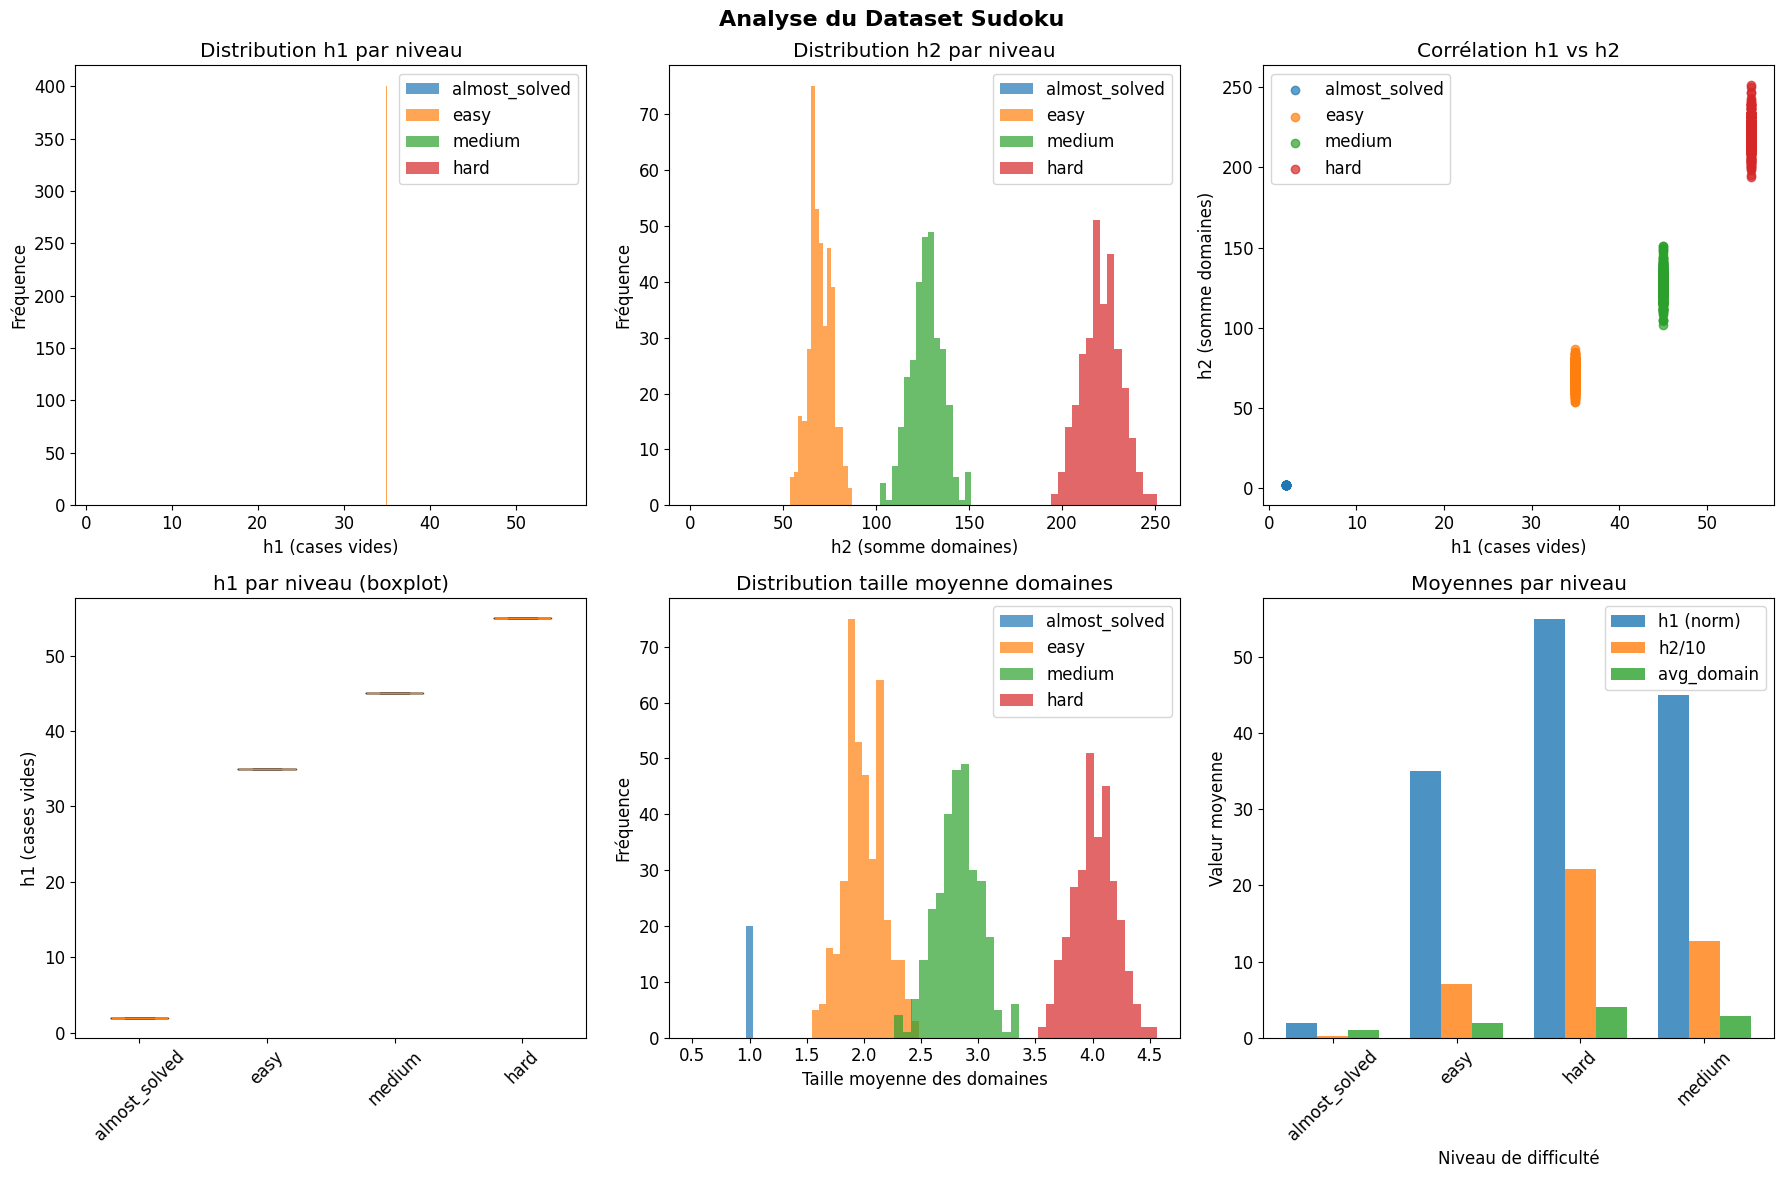


Analyse du dataset terminée.


In [2]:
# %% [markdown]
## 6. Analyse du dataset CSV

# %% 
# Chargement et analyse du dataset CSV (si disponible)
import os
from dataset_analyzer import SudokuDatasetAnalyzer, analyze_sudoku_dataset

csv_file = "./data/sudoku_dataset.csv"
if os.path.exists(csv_file):
    print("Dataset trouvé. Analyse en cours...")
    
    analyzer = analyze_sudoku_dataset(
        csv_path=csv_file,
        show_samples=True,
        create_plots=True
    )
    print("\nAnalyse du dataset terminée.")
    
else:
    print("Fichier 'sudoku_dataset.csv' non trouvé.")


### Analyse du dataset

- **Volume et validité** : le dataset contient 1020 grilles toutes valides, réparties en 4 niveaux de difficulté (almost_solved, easy, medium, hard). Cela offre une base solide et exploitable pour nos expérimentations.  

- **Diversité des niveaux** : la progression est nette entre les niveaux, aussi bien en nombre de cases vides ($h_1$) qu’en somme des domaines ($h_2$). Les valeurs moyennes confirment une augmentation progressive de la complexité.  

- **Corrélations** : $h_1$ et $h_2$ sont fortement corrélés, ce qui suggère une redondance. Néanmoins, $h_2$ affine mieux la notion de contrainte locale, ce qui pourra influencer les résultats de l’algorithme.  

- **Limite à noter** : toutes les grilles d’un même niveau possèdent exactement le même nombre de cases vides. Ainsi, $h_1$ seul ne permet pas de discriminer les grilles à l’intérieur d’un niveau. C’est toutefois une bonne base pour mettre en évidence les limites de $h_1$ et montrer l’intérêt d’utiliser $h_2$.  

En conclusion, ce dataset est suffisamment volumineux et équilibré pour analyser l’efficacité des heuristiques de sélection dans notre solveur, tout en révélant les complémentarités entre $h_1$ et $h_2$.



Grille almost_solved_001 (niveau: almost_solved)
  h1: OK (3 états, 0.000s)
  h2: OK (3 états, 0.000s)
  h3: OK (3 états, 0.000s)

Grille almost_solved_002 (niveau: almost_solved)
  h1: OK (3 états, 0.000s)
  h2: OK (3 états, 0.000s)
  h3: OK (3 états, 0.000s)

Grille easy_001 (niveau: easy)
  h1: OK (36 états, 0.006s)
  h2: OK (36 états, 0.005s)
  h3: OK (36 états, 0.006s)

Grille easy_002 (niveau: easy)
  h1: OK (36 états, 0.006s)
  h2: OK (36 états, 0.074s)
  h3: OK (36 états, 0.006s)

Grille medium_001 (niveau: medium)
  h1: OK (46 états, 0.008s)
  h2: OK (46 états, 0.008s)
  h3: OK (46 états, 0.009s)

Grille medium_002 (niveau: medium)
  h1: OK (46 états, 0.008s)
  h2: OK (46 états, 0.008s)
  h3: OK (46 états, 0.008s)

Grille hard_001 (niveau: hard)
  h1: OK (279 états, 0.046s)
  h2: OK (318 états, 0.051s)
  h3: OK (318 états, 0.052s)

Grille hard_002 (niveau: hard)
  h1: OK (938 états, 0.133s)
  h2: OK (189 états, 0.032s)
  h3: OK (189 états, 0.034s)


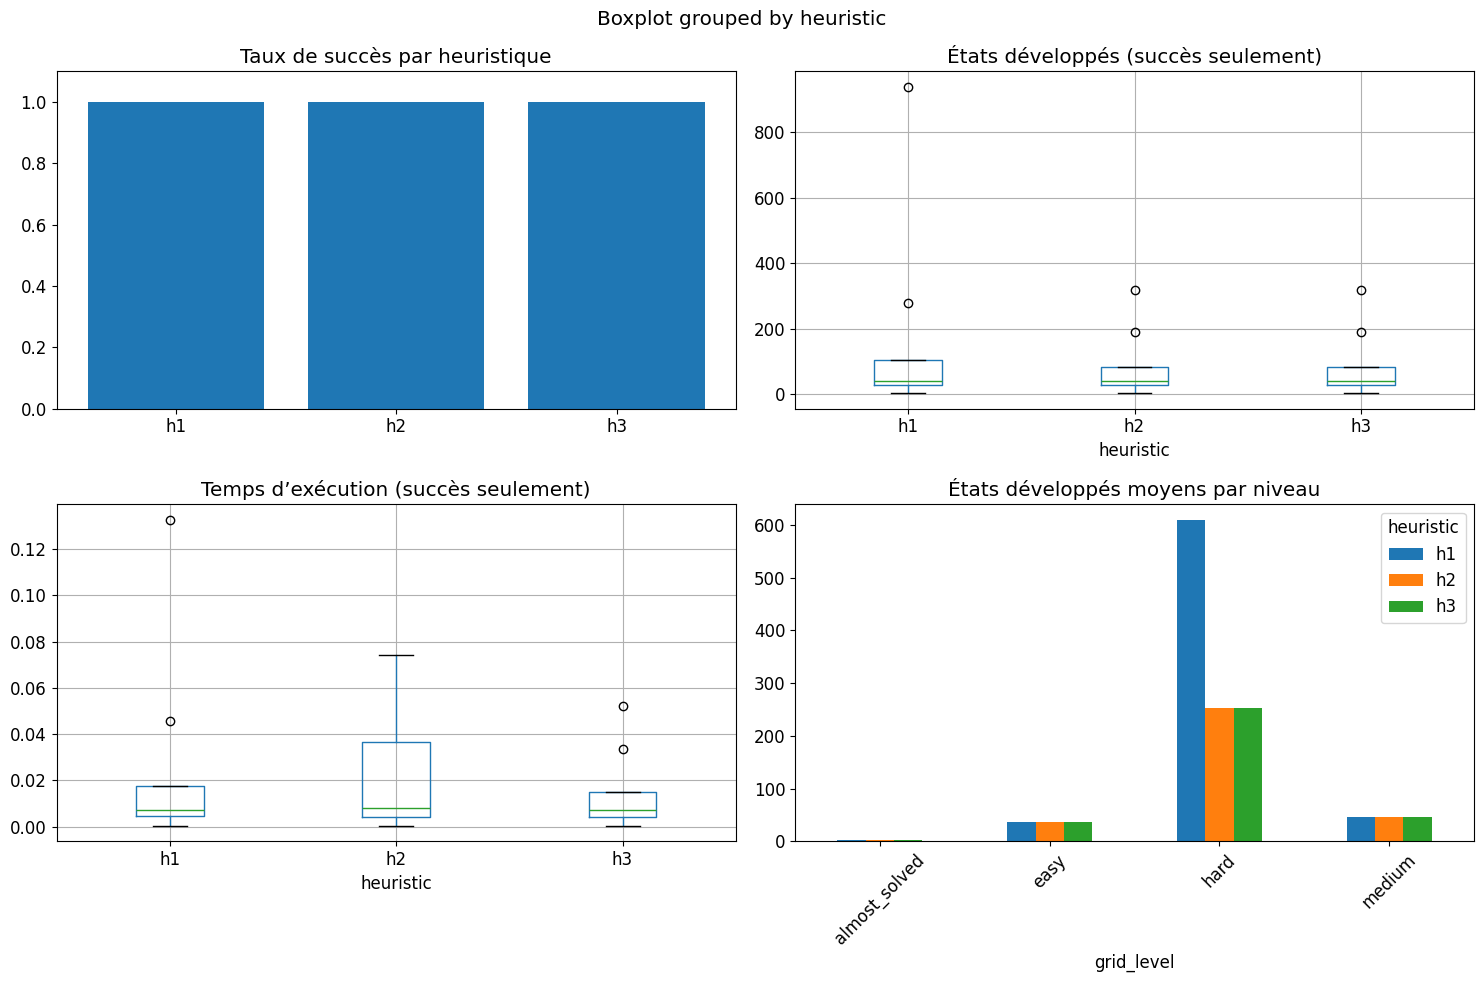

In [3]:
# Tests GBFS sur le dataset

def test_gbfs_on_dataset_sample(analyzer, n_samples=5, max_iterations=10000):
    """Teste GBFS sur un échantillon de grilles du dataset."""
    if not hasattr(analyzer, 'sudoku_states') or len(analyzer.sudoku_states) == 0:
        print("Pas de grilles valides dans le dataset.")
        return None
    
    # Sélection d’un échantillon représentatif
    sample_grids = []
    heuristics_df = analyzer.analysis_results.get('heuristics', None)
    if heuristics_df is not None:
        for level in heuristics_df['level'].unique():
            level_grids = heuristics_df[heuristics_df['level'] == level]
            n_per_level = min(2, len(level_grids))
            sample_grids.extend(level_grids.head(n_per_level).to_dict('records'))
    else:
        sample_grids = [{'index': i} for i in range(min(n_samples, len(analyzer.sudoku_states)))]
    sample_grids = sample_grids[:n_samples]

    heuristics_to_test = [
        ('h1', h1_empty_cells, None),
        ('h2', h2_domain_sum, None),
        ('h3', h3_weighted_combination, {'w1': 1.0, 'w2': 0.1}),
    ]
    
    results = []
    for grid_info in sample_grids:
        grid_idx = grid_info['index']
        grid_id = analyzer.df.iloc[grid_idx]['id']
        grid_level = analyzer.df.iloc[grid_idx]['level']
        state = analyzer.sudoku_states[grid_idx]
        
        print(f"\nGrille {grid_id} (niveau: {grid_level})")
        for h_name, h_func, h_params in heuristics_to_test:
            if h_params:
                def h_with_params(s): return h_func(s, **h_params)
                solver = GBFSSolver(h_with_params)
            else:
                solver = GBFSSolver(h_func)
            
            stats = solver.solve(state, max_iterations=max_iterations)
            results.append({
                'grid_id': grid_id,
                'grid_level': grid_level,
                'heuristic': h_name,
                'success': stats.success,
                'states_developed': stats.states_developed,
                'execution_time': stats.execution_time,
                'max_open_size': stats.max_open_size
            })
            status = "OK" if stats.success else "Échec"
            print(f"  {h_name}: {status} ({stats.states_developed} états, {stats.execution_time:.3f}s)")
    
    return pd.DataFrame(results) if results else None

if os.path.exists(csv_file) and 'analyzer' in locals():
    dataset_results = test_gbfs_on_dataset_sample(analyzer, n_samples=8)
else:
    dataset_results = None


## Visualisation des performances GBFS

if dataset_results is not None and len(dataset_results) > 0:
    successful_results = dataset_results[dataset_results['success']]
    if len(successful_results) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Performance GBFS sur le dataset', fontsize=16)
        
        # 1. Taux de succès
        success_rates = dataset_results.groupby('heuristic')['success'].mean()
        axes[0,0].bar(success_rates.index, success_rates.values)
        axes[0,0].set_title('Taux de succès par heuristique')
        axes[0,0].set_ylim(0, 1.1)
        
        # 2. États développés (succès seulement)
        successful_results.boxplot(column='states_developed', by='heuristic', ax=axes[0,1])
        axes[0,1].set_title('États développés (succès seulement)')
        
        # 3. Temps d’exécution (succès seulement)
        successful_results.boxplot(column='execution_time', by='heuristic', ax=axes[1,0])
        axes[1,0].set_title('Temps d’exécution (succès seulement)')
        
        # 4. États développés moyens par niveau
        perf_by_level = successful_results.groupby(['grid_level', 'heuristic'])['states_developed'].mean().unstack()
        perf_by_level.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('États développés moyens par niveau')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()



## **4. Test sur un exemple difficile**

Le soucis avec les exemples du dessus, c'est qu'ils Ici on veut tester sudoku sur un exemple avec peu de contraintes. Comme ça ça fait plus de choix à chaque étape; 


In [5]:
from sudoku_state import SudokuState

# ANALYSE DÉTAILLÉE DE L'ÉCHEC GBFS
print("ANALYSE DÉTAILLÉE DE L'ÉCHEC GBFS")
print("=" * 50)

def create_open_sudoku():
    """Crée un Sudoku avec plus de choix à chaque étape."""
    
    # Commencer avec une grille partiellement remplie mais "ouverte"
    grid = [
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 3, 0, 8, 5],
        [0, 0, 1, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 5, 0, 7, 0, 0, 0],
        [0, 0, 4, 0, 0, 0, 1, 0, 0],
        [0, 9, 0, 0, 0, 0, 0, 0, 0],
        [5, 0, 0, 0, 0, 0, 0, 7, 3],
        [0, 0, 2, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 4, 0, 0, 0, 9]
    ]
    
    return SudokuState(grid)

# Créer la grille problématique
open_state = create_open_sudoku()

print("GRILLE À ANALYSER:")
print_state(open_state, "Grille ouverte")

print(f"\n" + "="*70)
print("TEST")
print("="*70)

# Test avec limite élevée sans verbose pour voir si ça aboutit
print("Test h1 avec 100 000 itérations (avec verbose)...")
solver_h1 = GBFSSolver(h1_empty_cells)
stats_h1 = solver_h1.solve(open_state, max_iterations=100000, verbose=True)

# print("Test h2 avec 100 000 itérations (sans verbose)...")
# solver_h2  = GBFSSolver(h2_domain_sum)
# stats_h2 = solver_h2.solve(open_state, max_iterations=100000, verbose=True)



# Comprendre pourquoi GBFS échoue
def analyze_gbfs_failure(state, max_steps=100):
    """Analyse les premiers pas de GBFS pour comprendre l'échec."""
    
    print("ANALYSE DE L'ÉCHEC GBFS")
    print("=" * 30)
    
    solver = GBFSSolver(h2_domain_sum)
    
    # Modification temporaire pour tracer les premiers états
    current_state = state
    
    for step in range(max_steps):
        print(f"\nÉtape {step}:")
        print(f"  h1: {h1_empty_cells(current_state)}")
        print(f"  h2: {h2_domain_sum(current_state)}")
        print_state(current_state, f"État actuel (étape {step})")
        
        successors = current_state.generate_successors()
        print(f"  Successeurs: {len(successors)}")
        
        if current_state.is_goal():
            print("  -> SOLUTION TROUVÉE !")
            break

        if len(successors) == 0:
            print("  -> IMPASSE ! Aucun successeur valide.")
            break
        
        # Prendre le meilleur successeur selon h2
        best_successor = min(successors, key=h2_domain_sum)
        current_state = best_successor
    
    return current_state

# Analyser l'échec
open_state = create_open_sudoku()
final_state = analyze_gbfs_failure(open_state)

ANALYSE DÉTAILLÉE DE L'ÉCHEC GBFS
GRILLE À ANALYSER:

=== Grille ouverte ===
┌───────┬───────┬───────┐
│ . . . │ . . . │ . . . │
│ . . . │ . . 3 │ . 8 5 │
│ . . 1 │ . 2 . │ . . . │
├───────┼───────┼───────┤
│ . . . │ 5 . 7 │ . . . │
│ . . 4 │ . . . │ 1 . . │
│ . 9 . │ . . . │ . . . │
├───────┼───────┼───────┤
│ 5 . . │ . . . │ . 7 3 │
│ . . 2 │ . 1 . │ . . . │
│ . . . │ . 4 . │ . . 9 │
└───────┴───────┴───────┘
Nombre de cases vides: 64

TEST
Test h1 avec 100 000 itérations (avec verbose)...
DÉMARRAGE GBFS VERBOSE

=== État initial ===
┌───────┬───────┬───────┐
│ . . . │ . . . │ . . . │
│ . . . │ . . 3 │ . 8 5 │
│ . . 1 │ . 2 . │ . . . │
├───────┼───────┼───────┤
│ . . . │ 5 . 7 │ . . . │
│ . . 4 │ . . . │ 1 . . │
│ . 9 . │ . . . │ . . . │
├───────┼───────┼───────┤
│ 5 . . │ . . . │ . 7 3 │
│ . . 2 │ . 1 . │ . . . │
│ . . . │ . 4 . │ . . 9 │
└───────┴───────┴───────┘
Cases vides: 64
Valeur heuristique initiale: 64

=== Informations sur les domaines (64 cases vides) ===
Case (2,3): {6, 

## 6. Conclusion et observations

### Observations clés :

1. **Heuristique h1** : Simple et efficace pour les exemples faciles
2. **Heuristique h2** : Prend en compte la contrainte des domaines
3. **Heuristique h3** : Permet de balancer entre rapidité et qualité de guidage

### Points d'amélioration possibles :
- Implémenter des heuristiques plus sophistiquées
- Ajouter des techniques de préprocessing
- Tester A* au lieu de GBFS pur

### Performance :
L'algorithme GBFS fonctionne bien sur les exemples de difficulté faible à moyenne.
Pour les exemples très difficiles, il peut être nécessaire d'augmenter la limite d'itérations
ou d'utiliser des heuristiques plus informées.